# CMIP6 historical period

Mean fields

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import xesmf as xe
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:34491 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 250.00 GiB


In [2]:
def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

def circumpolar_map(*, land = True):
    
    fig = plt.figure(figsize = (28, 10))
    axs = [fig.add_subplot(221, projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(222, projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(223, projection = ccrs.Mercator(central_longitude = 200)),
           fig.add_subplot(224, projection = ccrs.Mercator(central_longitude = 200))]
    for ax in axs:
        ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
        if land:
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                           edgecolor = 'black', facecolor = 'white'))
        else:
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                           edgecolor = 'black', facecolor = 'none'))
        ax.set_xticks(np.arange(-150, 200, 50), crs = ccrs.PlateCarree())
        ax.set_yticks([-75, -70, -65, -60, -55], crs = ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label = False)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
    
    return fig, axs

def extract_so(ds):
    ds_so = ds.sel(lat = slice(None, -50))
    return ds_so

def multimodel_map():
    
    fig = plt.figure(figsize = (30, 30))
    gr = gs.GridSpec(5, 5, figure = fig, height_ratios = [1, 1, 1, 1, .1]); axs = []
    for i in range(4):
        for j in range(5):
            axs.append(fig.add_subplot(gr[i,j], projection = ccrs.SouthPolarStereo()))
    axs.append(fig.add_subplot(gr[4,1:-1]))
    for ax in axs[:-1]:
        ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)
    
    return fig, axs

def southern_ocean_plot():
    fig = plt.figure(1, figsize = (16, 12))
    ax1 = fig.add_axes([0.0, 0.5, 0.5, 0.5], projection = ccrs.SouthPolarStereo())
    ax1.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform = ax1.transAxes)
    
    ax2 = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection = ccrs.SouthPolarStereo())
    ax2.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax2.set_boundary(circle, transform = ax2.transAxes)
    
    ax3 = fig.add_axes([0.3, 0.43, 0.3, 0.02])
    plt.tight_layout()
    return fig, [ax1, ax2, ax3]

## Regrid (to calculate ensemble mean with cdo)

Only run this once

In [37]:
jra = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/*')

for i in range(len(path_uas)):
    
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    
    ds = xr.open_dataset(path_uas[i])
    ds_in = ds['uas'].to_dataset()
    ds_out = jra['uas'].to_dataset()
    
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    dr_out.to_netcdf('/scratch/e14/jn8053/cmip6/historical/uas-regrid/uas_historical_'+model_name+'.nc')

jra = xr.open_dataset('/scratch/e14/jn8053/jra55/vas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/*')

for i in range(len(path_uas)):
    
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    
    ds = xr.open_dataset(path_vas[i])
    ds_in = ds['vas'].to_dataset()
    ds_out = jra['vas'].to_dataset()
    
    regrid = xe.Regridder(ds_in, ds_out, 'conservative')
    dr_out = regrid(ds_in)
    dr_out.to_netcdf('/scratch/e14/jn8053/cmip6/historical/vas-regrid/vas_historical_'+model_name+'.nc')

## Historical (1958 - 2015)

### Load `uas` and `vas`

In [3]:
# JRA55do-v14
uas = {}
vas = {}
uas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
vas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/vas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-monthly-1958_2015.nc')
vas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-monthly-1958_2015.nc')

# CMIP6 individual models
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas[model_name] = xr.open_dataset(path_uas[i])
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas[model_name] = xr.open_dataset(path_vas[i])
model_names = list(uas.keys())

In [4]:
mask_file = np.load('/g/data/e14/hd4873/runs/parcels/input/proj01/Antarctic_slope_contour_ht_1000m.npz')
shelf_mask = mask_file['contour_masked_above']
xt_ocean = mask_file['xt_ocean']
yt_ocean = mask_file['yt_ocean']
shelf_mask[shelf_mask != 0] = np.nan
shelf_mask[shelf_mask == 0] = 1
shelf_mask = xr.DataArray(shelf_mask, dims = ['yt_ocean', 'xt_ocean'], coords = {'yt_ocean':yt_ocean, 'xt_ocean':xt_ocean})
mask = change_lon_space(shelf_mask, 't')
mask = mask.interp(lon = uas['JRA']['lon'], lat = uas['JRA']['lat'])

### Plot historical means

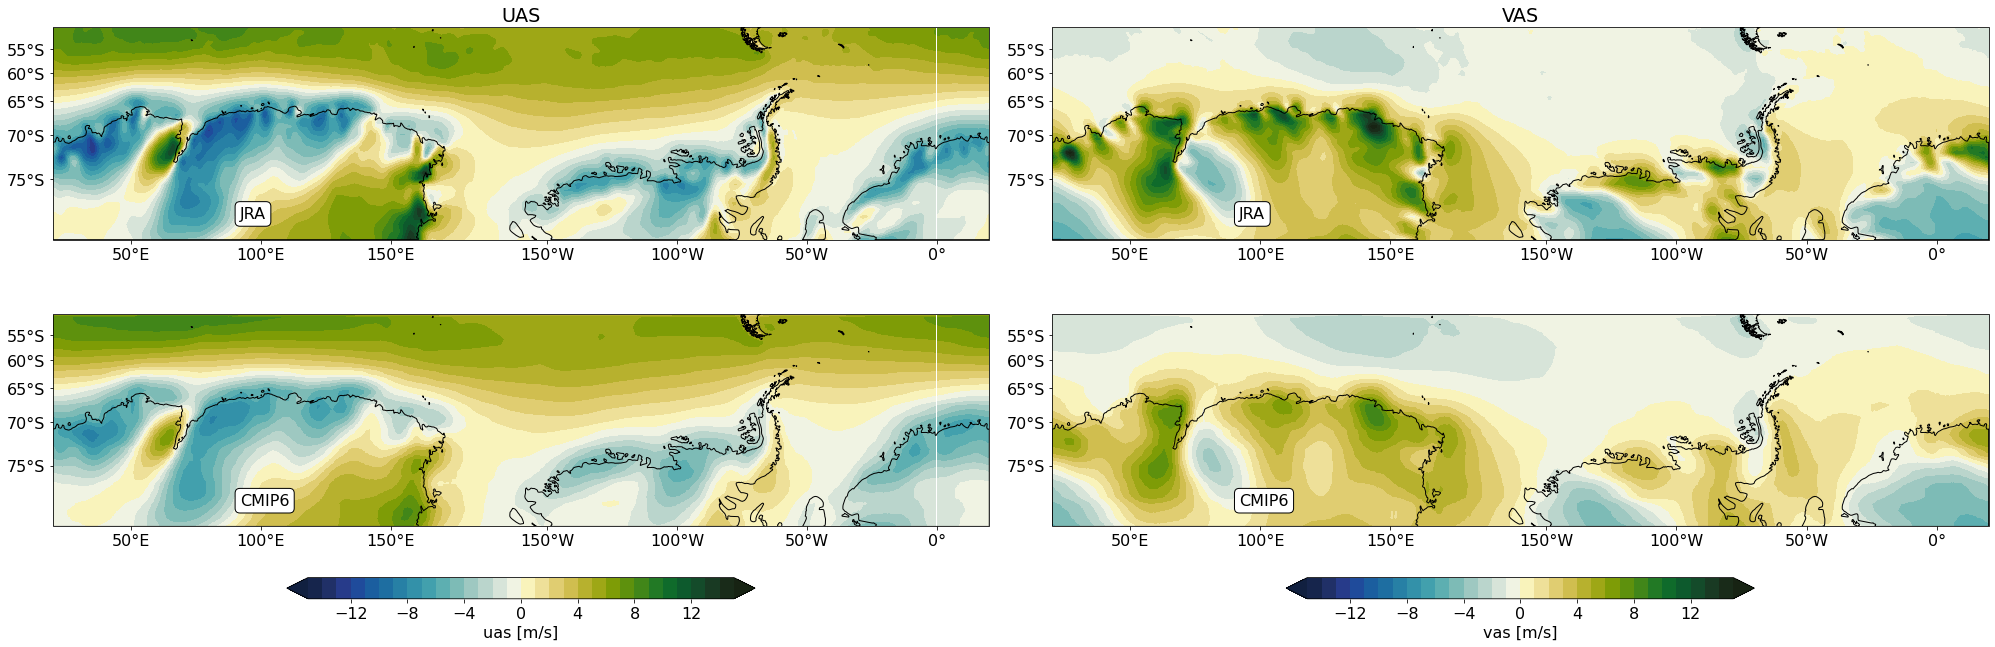

In [7]:
fig, axs = circumpolar_map(land = False)
n = 0
for i in ['JRA', 'CMIP6']:
    cu = axs[2*n].contourf(uas[i]['lon'], uas[i]['lat'], uas[i]['uas'].mean('time'), levels = np.arange(-15, 16, 1), 
                         cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
    cv = axs[2*n+1].contourf(vas[i]['lon'], vas[i]['lat'], vas[i]['vas'].mean('time'), levels = np.arange(-15, 16, 1), 
                             cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
    axs[2*n].text(0.2, 0.1, i, transform = axs[2*n].transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
    axs[2*n+1].text(0.2, 0.1, i, transform = axs[2*n+1].transAxes, bbox = dict(boxstyle = 'round', facecolor = 'white'))
    n += 1
fig.colorbar(cu, ax = axs[2], orientation = 'horizontal', shrink = .5).set_label('uas [m/s]')
fig.colorbar(cv, ax = axs[3], orientation = 'horizontal', shrink = .5).set_label('vas [m/s]')
axs[0].set_title('UAS')
axs[1].set_title('VAS')
plt.tight_layout()
plt.savefig(figdir+'/easterlies-collaborative/cmip6/mean/uas_vas-historical-mean-jra_cmip.png', facecolor = 'white', bbox_inches = 'tight')

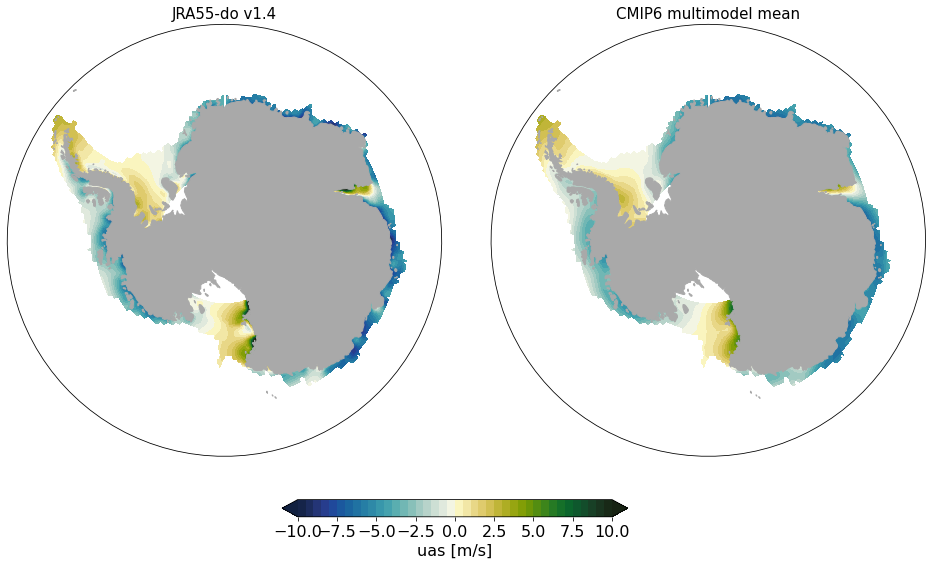

In [5]:
fig, axs = southern_ocean_plot(); n = 0
for name in ['JRA', 'CMIP6']:
    c = axs[n].contourf(uas[name]['lon'], uas[name]['lat'], uas[name]['uas'].mean('time')*mask, levels = np.arange(-10, 10.5, .5), 
                         cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
    n += 1
axs[0].set_title('JRA55-do v1.4', fontsize = 15)
axs[1].set_title('CMIP6 multimodel mean', fontsize = 15)
cbar = fig.colorbar(c, cax = axs[-1], orientation = 'horizontal', shrink = .5)
cbar.set_label('uas [m/s]')
plt.savefig(figdir+'/easterlies-collaborative/cmip6/mean/uas_stereo-historical-mean-jra_cmip.png', facecolor = 'white', bbox_inches = 'tight')

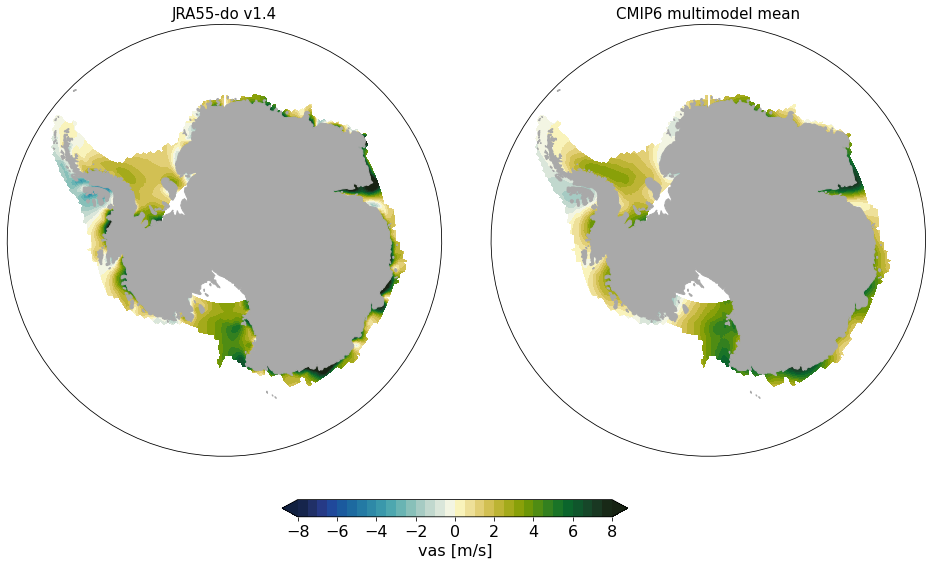

In [6]:
fig, axs = southern_ocean_plot(); n = 0
for name in ['JRA', 'CMIP6']:
    c = axs[n].contourf(vas[name]['lon'], vas[name]['lat'], vas[name]['vas'].mean('time')*mask, levels = np.arange(-8, 8.5, .5), 
                         cmap = cmocean.cm.delta, extend = 'both', transform = ccrs.PlateCarree())
    n += 1
axs[0].set_title('JRA55-do v1.4', fontsize = 15)
axs[1].set_title('CMIP6 multimodel mean', fontsize = 15)
cbar = fig.colorbar(c, cax = axs[-1], orientation = 'horizontal', shrink = .5)
cbar.set_label('vas [m/s]')
plt.savefig(figdir+'/easterlies-collaborative/cmip6/mean/vas_stereo-historical-mean-jra_cmip.png', facecolor = 'white', bbox_inches = 'tight')

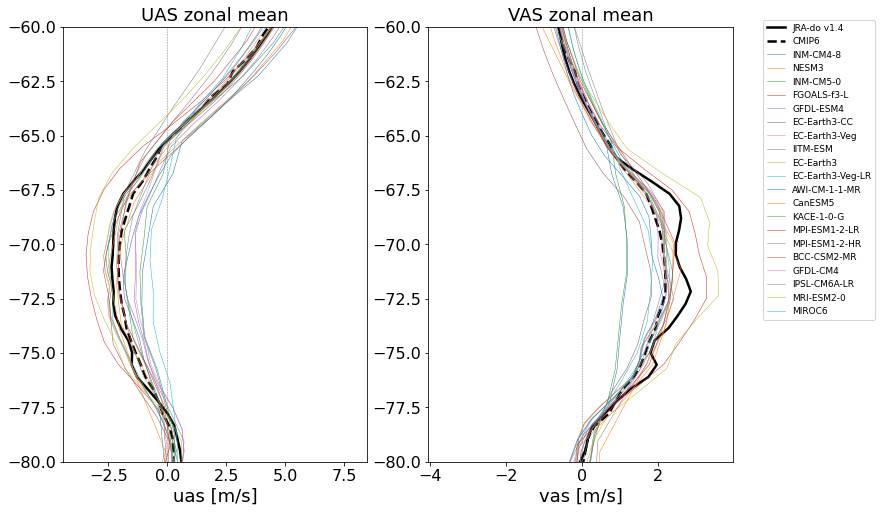

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (12, 8))
axs[0].axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
axs[1].axvline(x = 0, linestyle = '--', linewidth = 0.5, color = 'grey')
for i in range(0, len(model_names)):
    if model_names[i] == 'JRA':
        axs[0].plot(uas[model_names[i]]['uas'].mean('time').mean('lon'), uas[model_names[i]]['lat'], color = 'k', linewidth = 2.5)
        axs[1].plot(vas[model_names[i]]['vas'].mean('time').mean('lon'), vas[model_names[i]]['lat'], color = 'k', linewidth = 2.5, label = model_names[i]+'-do v1.4')
    elif model_names[i] == 'CMIP6':
        axs[0].plot(uas[model_names[i]]['uas'].mean('time').mean('lon'), uas[model_names[i]]['lat'], color = 'k', linewidth = 2.5, linestyle = '--')
        axs[1].plot(vas[model_names[i]]['vas'].mean('time').mean('lon'), vas[model_names[i]]['lat'], color = 'k', linewidth = 2.5, linestyle = '--', label = model_names[i])
    else:
        axs[0].plot(uas[model_names[i]]['uas'].mean('time').mean('lon'), uas[model_names[i]]['lat'], linewidth = 0.5)   
        axs[1].plot(vas[model_names[i]]['vas'].mean('time').mean('lon'), vas[model_names[i]]['lat'], linewidth = 0.5, label = model_names[i])    
axs[0].set_ylim(-80, -60); axs[1].set_ylim(-80, -60)
axs[0].set_title('UAS zonal mean', fontsize = 18)
axs[1].set_title('VAS zonal mean', fontsize = 18)
axs[0].set_xlabel('uas [m/s]', fontsize = 18)
axs[1].set_xlabel('vas [m/s]', fontsize = 18)
fig.legend(ncol = 1, bbox_to_anchor = (1, .9), fontsize = 9, loc = 'upper center')
plt.savefig(figdir+'/easterlies-collaborative/cmip6/mean/uas_vas-zonal_mean.png', facecolor = 'white', bbox_inches = 'tight')

# Individual model differences with JRA55

In [9]:
mask_file = np.load('/g/data/e14/hd4873/runs/parcels/input/proj01/Antarctic_slope_contour_ht_1000m.npz')
shelf_mask = mask_file['contour_masked_above']
xt_ocean = mask_file['xt_ocean']
yt_ocean = mask_file['yt_ocean']
shelf_mask[shelf_mask != 0] = np.nan
shelf_mask[shelf_mask == 0] = 1
shelf_mask = xr.DataArray(shelf_mask, dims = ['yt_ocean', 'xt_ocean'], coords = {'yt_ocean':yt_ocean, 'xt_ocean':xt_ocean})
mask = change_lon_space(shelf_mask, 't')
mask = mask.interp(lon = uas['JRA']['lon'], lat = uas['JRA']['lat'])

In [11]:
uas_anom = {}
vas_anom = {}
# CMIP6 individual models in the same grid as JRA
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas-regrid/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas-regrid/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_anom[model_name] = xr.open_dataset(path_uas[i])
    uas_anom[model_name] = uas_anom[model_name]['uas'].mean('time') - uas['JRA']['uas'].mean('time')
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_anom[model_name] = xr.open_dataset(path_vas[i])
    vas_anom[model_name] = vas_anom[model_name]['vas'].mean('time') - vas['JRA']['vas'].mean('time')

model_names = list(uas_anom.keys())

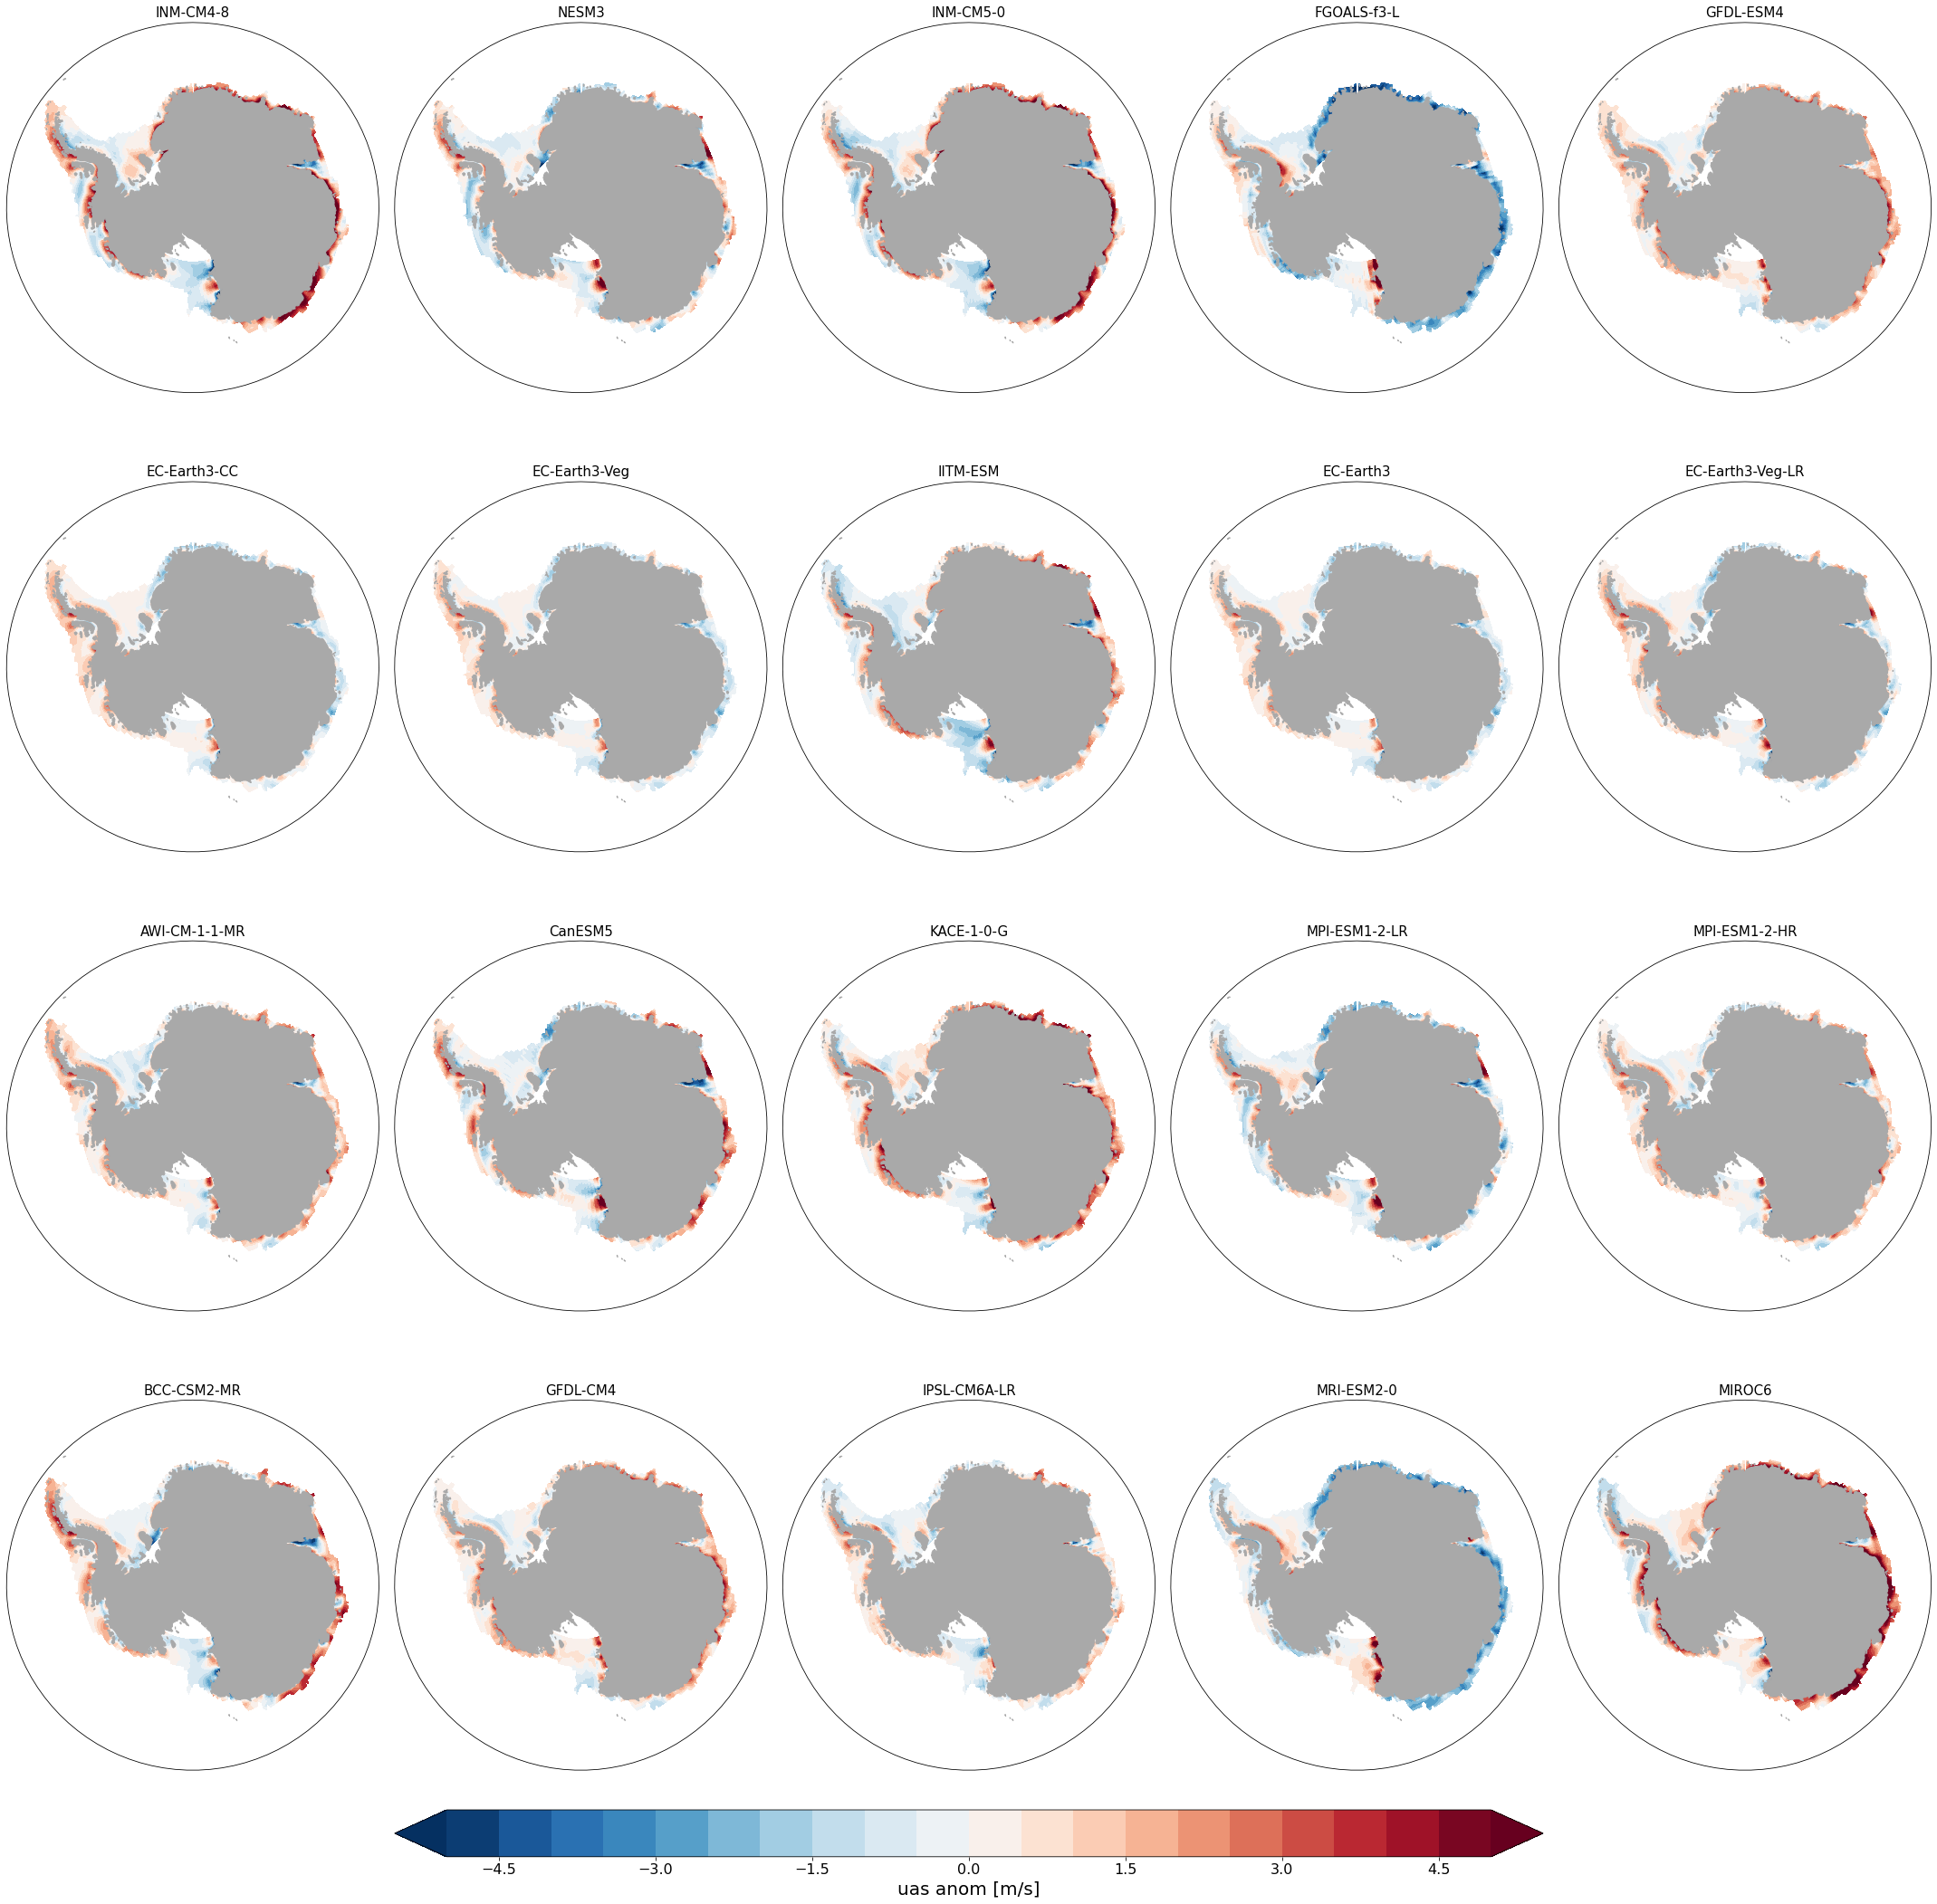

In [15]:
fig, axs = multimodel_map()
n = 0
for name in model_names:
    c = axs[n].contourf(uas_anom[name]['lon'], uas_anom[name]['lat'], uas_anom[name]*mask, 
                        levels = np.arange(-5, 5.5, .5), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
    axs[n].set_title(name, fontsize = 15); n+=1
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('uas anom [m/s]', fontsize = 20)
plt.tight_layout()

plt.savefig(figdir+'/easterlies-collaborative/cmip6/mean/uas-cmip-anom.png', facecolor = 'white', bbox_inches = 'tight')

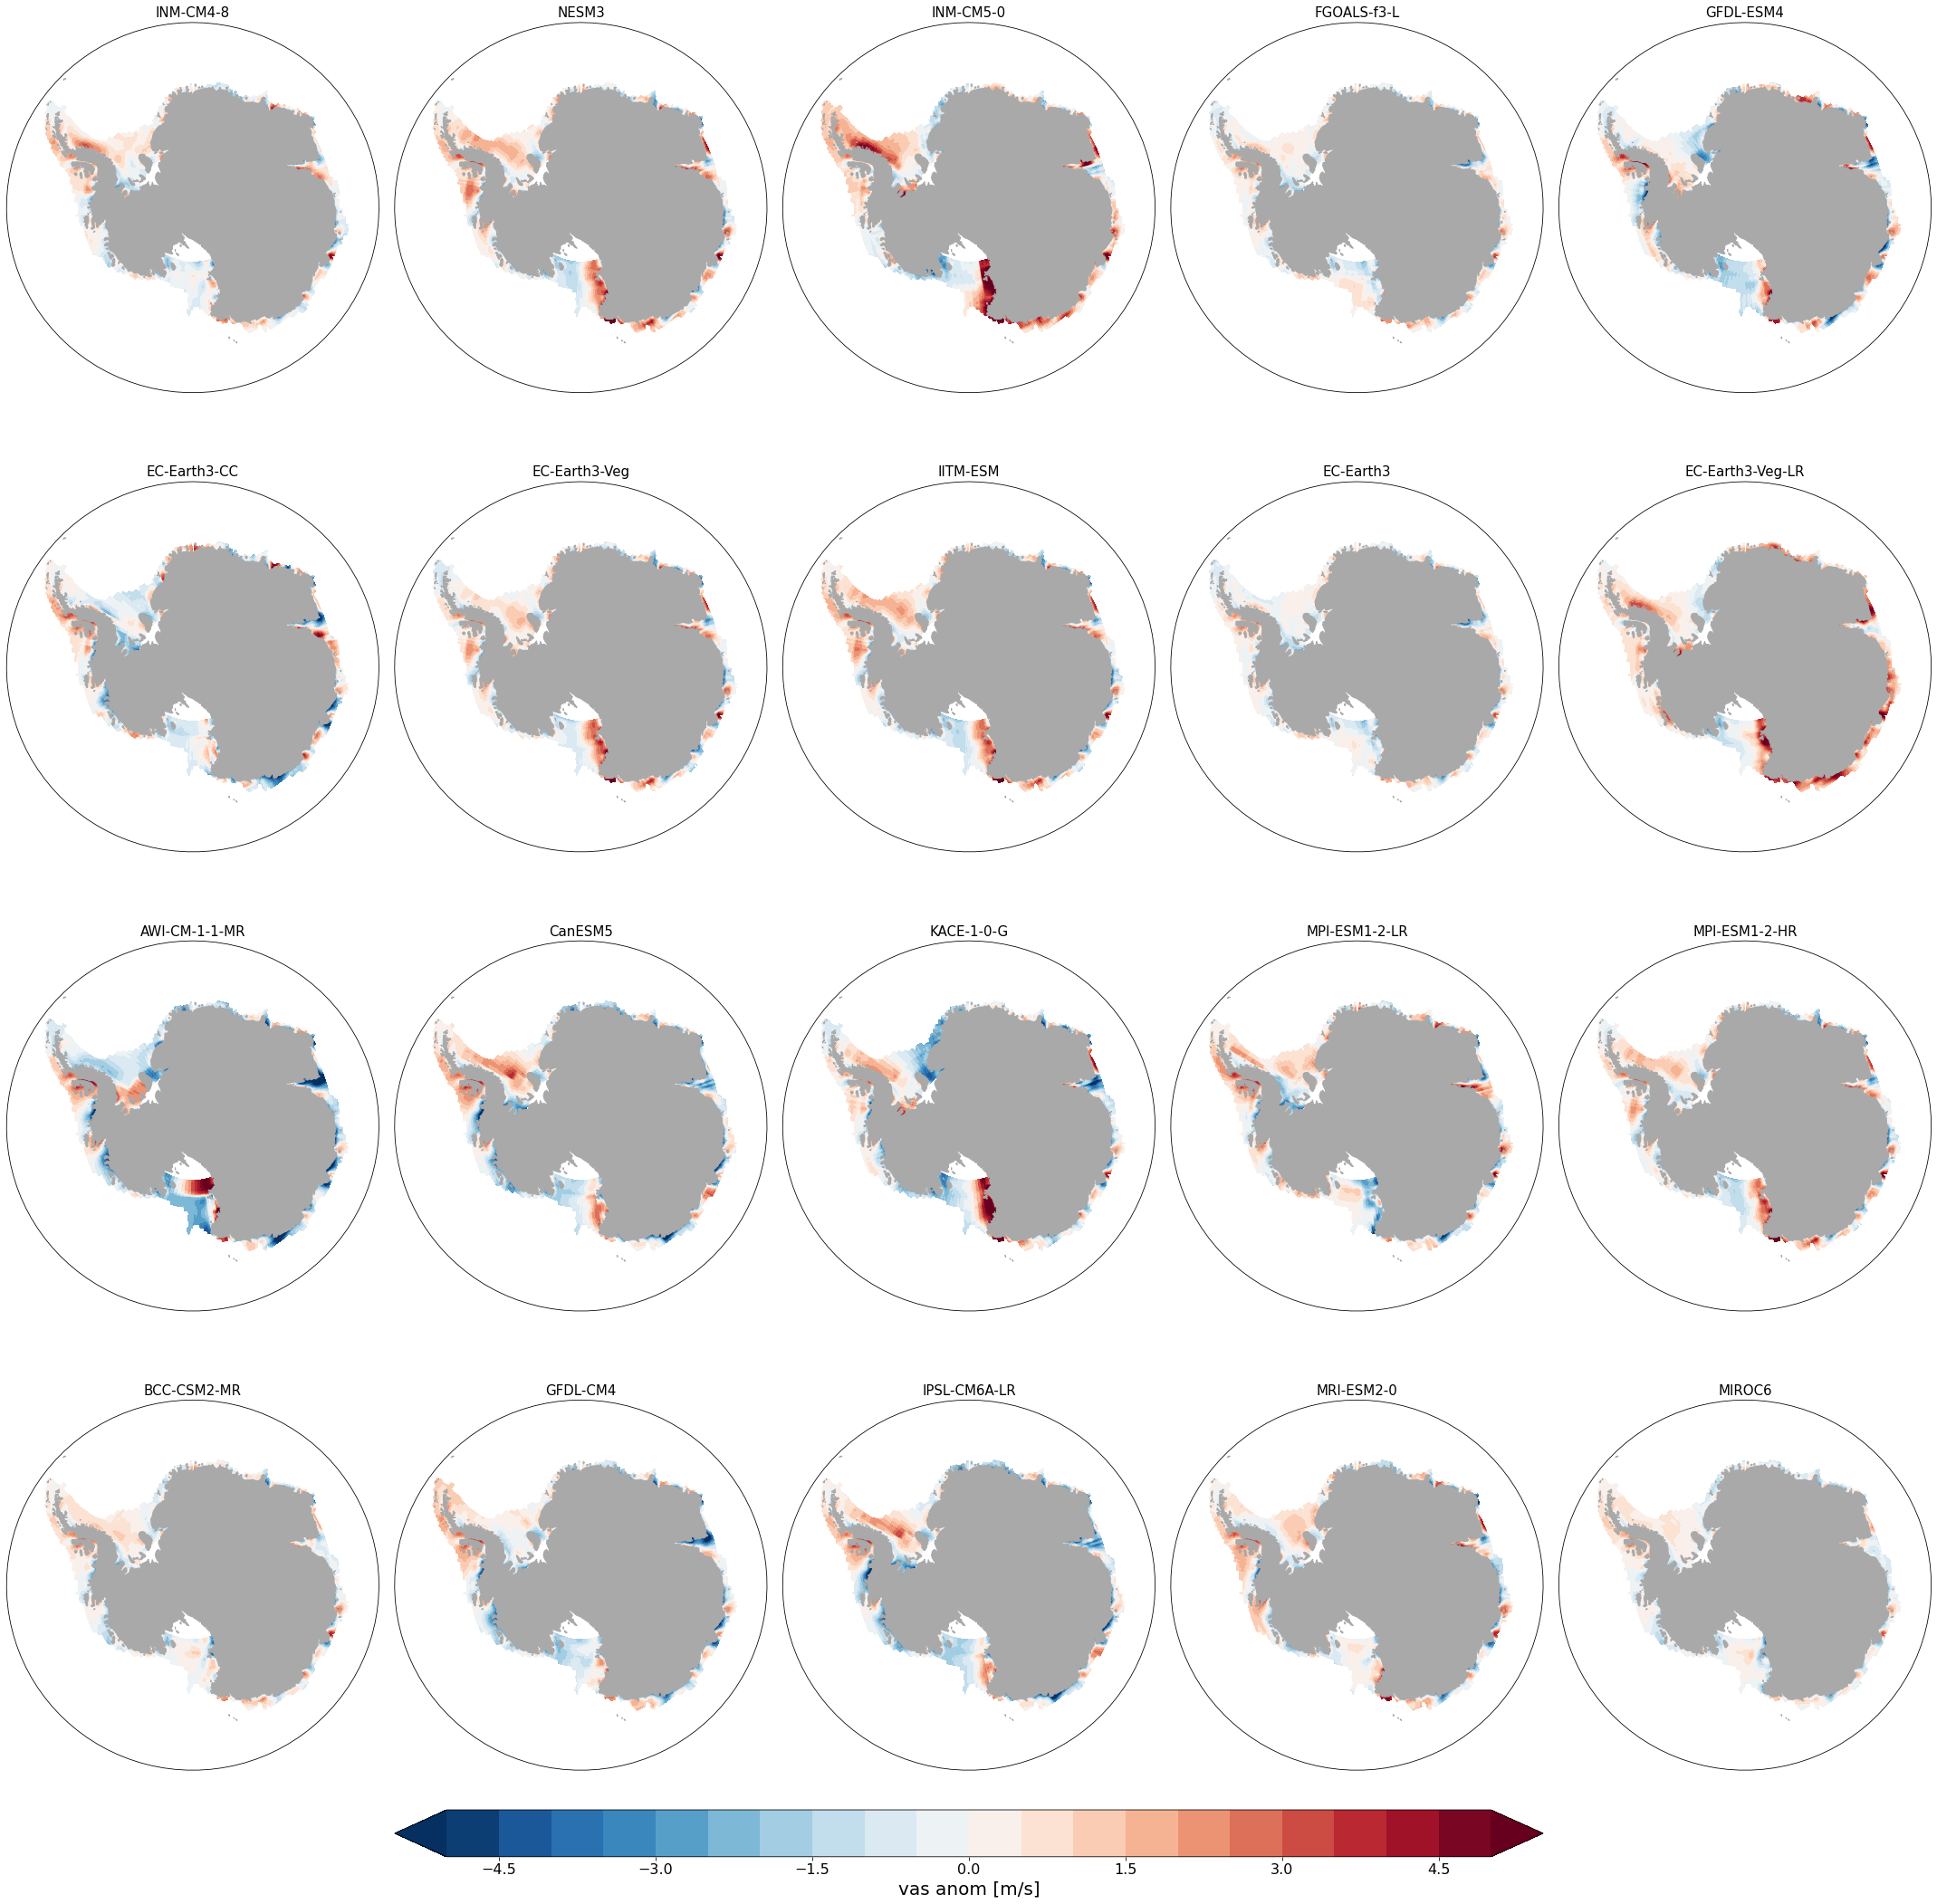

In [16]:
fig, axs = multimodel_map()
n = 0
for name in model_names:
    c = axs[n].contourf(vas_anom[name]['lon'], vas_anom[name]['lat'], vas_anom[name]*mask, 
                        levels = np.arange(-5, 5.5, .5), cmap = 'RdBu_r', extend = 'both', transform = ccrs.PlateCarree())
    axs[n].set_title(name, fontsize = 15); n+=1
fig.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('vas anom [m/s]', fontsize = 20)
plt.tight_layout()

plt.savefig(figdir+'/easterlies-collaborative/cmip6/mean/vas-cmip-anom.png', facecolor = 'white', bbox_inches = 'tight')